In [1]:
# ETL modules
import imageio
import numpy as np
import os
from pathlib import Path
from six.moves import cPickle as pickle
import ntpath

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

seed1 = 129
np.random.seed(seed1)

In [2]:
# Classification modules
from pathlib import Path
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

import datetime
datetime.datetime.now()

datetime.datetime(2024, 8, 11, 15, 17, 4, 956287)

In [3]:
from platform import python_version
print("Python version:", python_version())

Python version: 3.7.12


In [4]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.3


In [5]:
# Input
BASEDIR    = "/kaggle/input/handdrawn-shapes-hds-dataset"
DATA_DIR   = os.path.join(BASEDIR, "data")

# Output
MODEL_DIR  = os.path.join("/kaggle/working", "saved_models")
model_name = os.path.join(MODEL_DIR, "shapes.model.01") 

In [6]:
# Create Model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

<a id="split_users"></a>
## Split Users between the Train set, the Validation set and the Test set

In [7]:
# Define the Users for the validation set and the test set
# The Rest will go in the Training set
#
# The following definitions are arbitrary, but this is balanced and works well.
validation_users = ['crt', 'il1', 'lts', 'mrt', 'nae']
test_users =  ['u01', 'u17', 'u18', 'u19']

In [8]:
# Set image properties
image_size  = 70 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [9]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

num_classes = len(output_labels)

### Functions

In [10]:
def get_label_for_shape(shape_dir):
    shape = os.path.basename(shape_dir)
    if shape == "other":
        return 0
    elif shape == "ellipse":
        return 1
    elif shape == "rectangle":
        return 2
    elif shape == "triangle":
        return 3
    else:
        raise Exception(f"Unknown shape: {shape}")

In [11]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]

def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [12]:
def normalize_image(image_file, pixel_depth):
    """
    Normalize image by pixel depth by making it white on black instead of black on white
    """
    try:
        array = imageio.imread(image_file)
    except ValueError:
        raise

    return 1.0 - (array.astype(float))/pixel_depth  # (1 - x) will make it white on black

In [13]:
def load_images_for_shape(shape_directory, pixel_depth, 
                          user_images, user_images_labels,
                          shape_label, verbose=False, min_nimages=1):
    """
    Load all images for a specific user and shape into user_images.
    Labels are put in user_images_labels
    """  
    
    if verbose:
        print("directory for load_images_for_shapes: ", shape_directory)

    image_files = get_file_paths(shape_directory)
    image_index = 0

    for image_file in image_files:
        try:
            if path_leaf(image_file).startswith('.'):  # skip files like .DSStore
                continue

            image_data_all_channels = normalize_image(image_file, pixel_depth)
            image_data = image_data_all_channels[:, :, 0]

            user_images.append(image_data)
            user_images_labels.append(shape_label)
            image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image_file)

    if image_index < min_nimages:
        raise Exception(f'Fewer images than expected: {image_index} < {min_nimages}')

In [14]:
def load_images_for_user(user_directory, pixel_depth,
                         user_images, user_images_labels,
                         verbose=False):
    """
    Load all images for a specific user
    """      
    
    images_dir = os.path.join(user_directory, "images")

    if verbose:
        print("directory for load_images_for_shapes: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        label = get_label_for_shape(dir)
        if label >= 0:
            load_images_for_shape(dir, pixel_depth, user_images, user_images_labels, label)

In [15]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [16]:
def display_images(X, Y):
    """ 
    This function shows images with their real labels
    Presentation is rows of 10 images
    """

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.5)
    nb_pictures = len(X)
    nb_per_row = 10
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row, nb_per_row, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

In [17]:
# Get directory and file paths of Shape data
data_paths = get_dir_paths(DATA_DIR)
print(f"Dataset contains 1 directory per user:")
data_paths

Dataset contains 1 directory per user:


['/kaggle/input/handdrawn-shapes-hds-dataset/data/user.aly',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.crt',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.drt',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.elu',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.frt',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.if1',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.if2',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.if3',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.if5',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.if8',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.il1',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.ilb',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.im1',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.lrt',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.lt1',
 '/kaggle/input/handdrawn-shapes-hds-dataset/data/user.lts',
 '/kaggle/input/handdraw

<a id="training_data"></a>
## Training data

In [18]:
train_user_images = []
train_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id not in validation_users and user_id not in test_users:
        load_images_for_user(user_dir, pixel_depth, train_user_images, train_user_images_label)

train_data = np.array(train_user_images)
train_labels = np.array(train_user_images_label)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

unique, counts = np.unique(train_labels, return_counts=True)
print("train label dist.: ", dict(zip(unique, counts)))

train_data shape:  (21386, 70, 70)
train_labels shape:  (21386,)
train label dist.:  {0: 5316, 1: 5025, 2: 5737, 3: 5308}


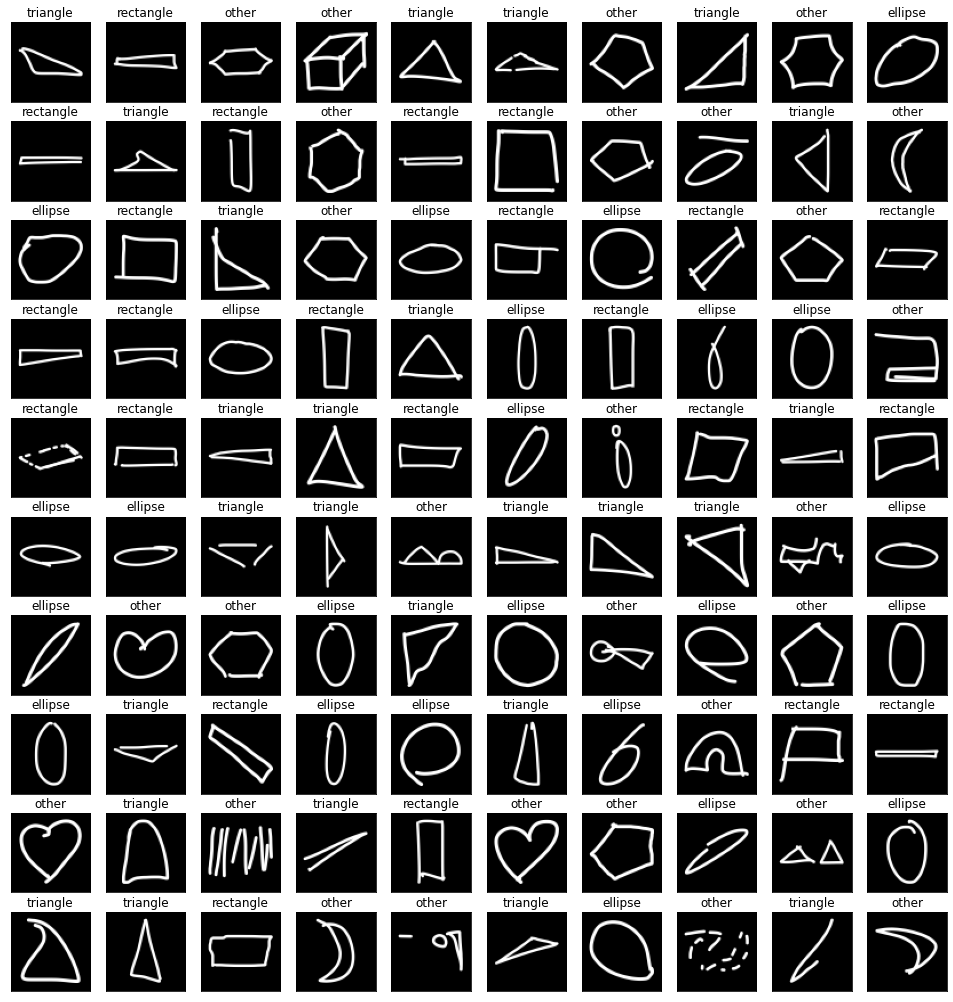

In [19]:
# Show random images from the Train Set
indexes = np.arange(len(train_labels))
np.random.shuffle(indexes)
first_random_indexes_tr = indexes[:100]

display_images(train_data[first_random_indexes_tr],train_labels[first_random_indexes_tr])

<a id="validation_data"></a>
## Validation data

In [20]:
val_user_images = []
val_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in validation_users:    
        load_images_for_user(user_dir, pixel_depth, val_user_images, val_user_images_label)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
unique, counts = np.unique(val_labels, return_counts=True)
print("val label dist.: ", dict(zip(unique, counts)))

val_data shape:  (3983, 70, 70)
val_labels shape:  (3983,)
val label dist.:  {0: 1130, 1: 1069, 2: 860, 3: 924}


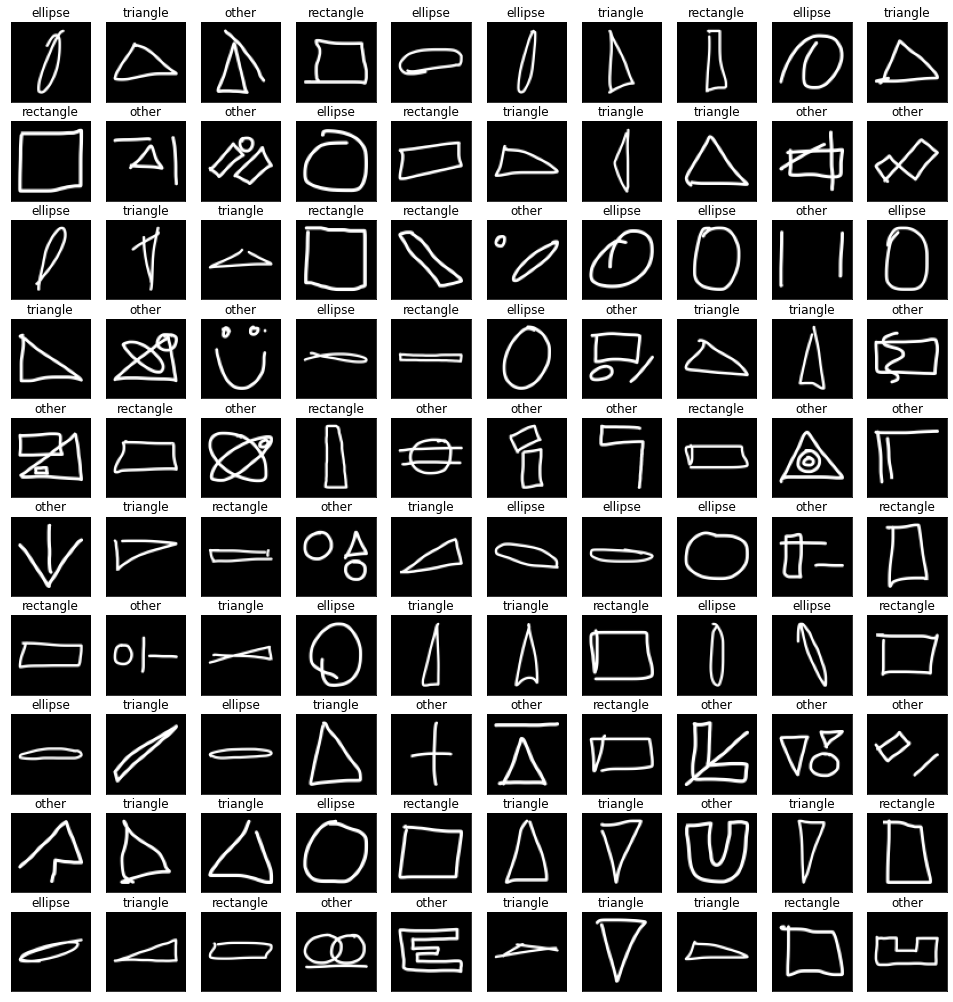

In [21]:
# Show random images from the Validation Set
indexes = np.arange(len(val_labels))
np.random.shuffle(indexes)
first_random_indexes_va = indexes[:100]

display_images(val_data[first_random_indexes_va],val_labels[first_random_indexes_va])

<a id="test_data"></a>
## Test data

In [22]:
test_user_images = []
test_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in test_users:  
        load_images_for_user(user_dir, pixel_depth, test_user_images, test_user_images_label)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)
unique, counts = np.unique(test_labels, return_counts=True)
print("test label dist.: ", dict(zip(unique, counts)))

test_data shape:  (1923, 70, 70)
test_labels shape:  (1923,)
test label dist.:  {0: 841, 1: 360, 2: 359, 3: 363}


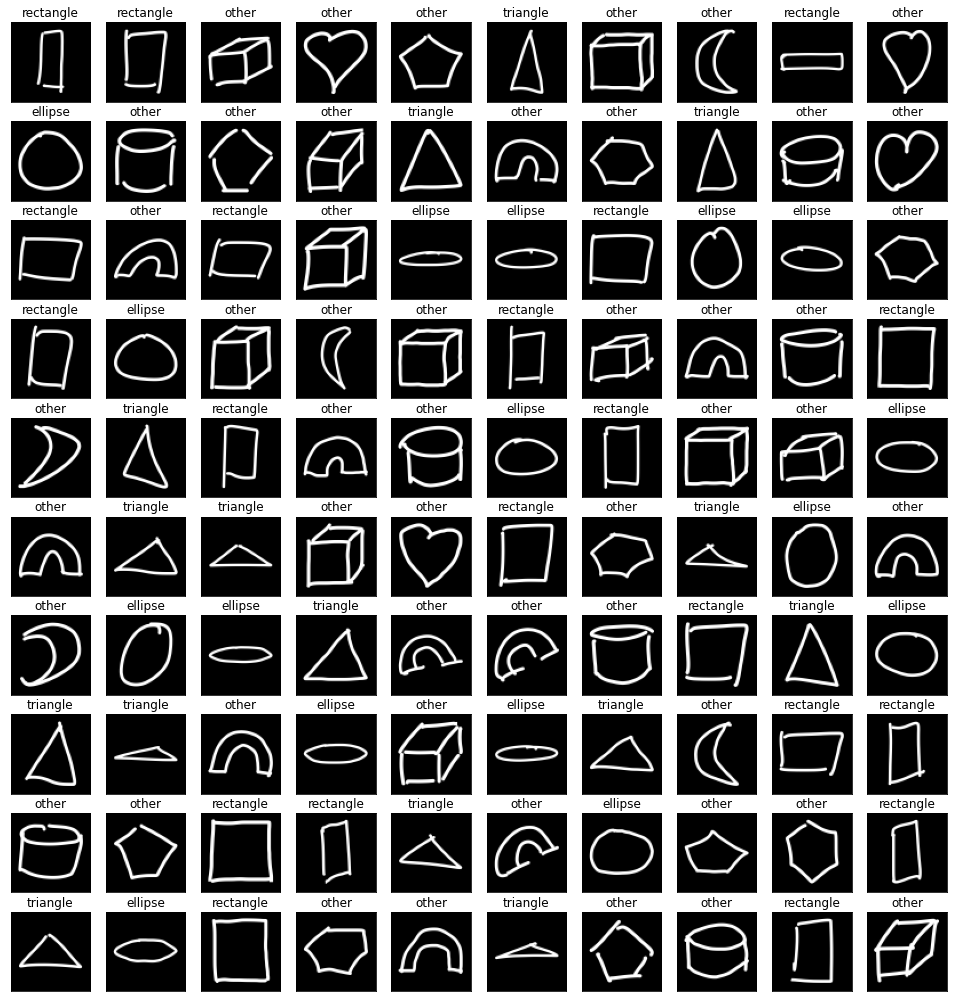

In [23]:
# Show random images from the Test Set
indexes = np.arange(len(test_labels))
np.random.shuffle(indexes)
first_random_indexes_te = indexes[:100]

display_images(test_data[first_random_indexes_te], test_labels[first_random_indexes_te])

## ETL Completed
---

In [24]:
datetime.datetime.now()

datetime.datetime(2024, 8, 11, 15, 22, 4, 126234)

<a id="classification"></a>
# 2. Classification - Train a model to learn the shape in an image

Shape categories are: Ellipse, Rectangle, Triangle and Other.  
Using Supervised Learning with Tensorflow.

In [25]:
## Construct train set
train_X = train_data
train_y = train_labels

In [26]:
## Construct validation set
val_X = val_data
val_y = val_labels

In [27]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (21386, 70, 70)
train_y shape:  (21386,)


In [28]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (3983, 70, 70)
val_y shape:  (3983,)


In [29]:
# Reshape images to add the channel (height = 70px, width = 70px, channel = 1)
X_train = train_X.reshape(-1, image_size, image_size, 1)
X_val   = val_X.reshape(-1, image_size, image_size, 1)

In [30]:
# Encode labels to one hot vectors using Keras one Hot encoding
Y_train = to_categorical(train_y, num_classes = num_classes)
Y_val   = to_categorical(val_y, num_classes = num_classes)

In [31]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_val shape: ", Y_val.shape)

X_train shape:  (21386, 70, 70, 1)
X_val shape:  (3983, 70, 70, 1)
Y_train shape:  (21386, 4)
Y_val shape:  (3983, 4)


In [32]:
tf.keras.backend.clear_session()

<a id="define_model"></a>
## Define the Model

In [33]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x) 

    x = Flatten()(x)
    x = Dense(200)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [34]:
# select a model
model = get_model_cnn()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 32)        128   

In [35]:
datagen = ImageDataGenerator(
        rotation_range=180,                  # Randomly rotate images in the range (degrees, 0 to +/-180)
#         zoom_range = [0.98, 1.02],         # Randomly zoom image a bit. Not required
        horizontal_flip=True,                # Randomly horizontal flip 
        vertical_flip=True)                  # Randomly vertical flip

### Define the optimizer

In [36]:
# Adam is generally my best bet for such classifications
optimizer = Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

In [37]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [38]:
# Keras callback to show the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

### Learning rate reduction

In [39]:
# Lower the learning rate if accuracy stops improving.
#
# Since the 360 rotation and the flips in Data Augmentation put a lot of variability in the Traning data,
# I typically run 200 to 300 epochs and only lower the learning rate very slowly.
# So, the correct setting for patience and factor are important to reach the best accuracy.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=15,
                                            verbose=1,
                                            factor=0.9,
                                            min_lr=0.000000001)

<a id="train_model"></a>
## Train the model

In [41]:
# Train and Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

# Training per epoch:
# - Kaggle: CPU (~100s) vs GPU (~11s) per epoch, so 9 times faster!
# - Using RTX2080: CPU (~150s) vs GPU (~6s) per epoch, so 25 times faster!
epochs = 10
batch_size = 128
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs=epochs, validation_data=(X_val,Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/10
167/167 [==============================] - 100s 601ms/step - loss: 0.1074 - accuracy: 0.9630 - val_loss: 0.0884 - val_accuracy: 0.9694

Epoch 00001: val_accuracy improved from -inf to 0.96937, saving model to /kaggle/working/saved_models/shapes.model.01.h5
Epoch 2/10
167/167 [==============================] - 100s 599ms/step - loss: 0.1219 - accuracy: 0.9578 - val_loss: 0.3330 - val_accuracy: 0.9046

Epoch 00002: val_accuracy did not improve from 0.96937
Epoch 3/10
167/167 [==============================] - 99s 592ms/step - loss: 0.1104 - accuracy: 0.9631 - val_loss: 0.1048 - val_accuracy: 0.9631

Epoch 00003: val_accuracy did not improve from 0.96937
Epoch 4/10
167/167 [==============================] - 99s 595ms/step - loss: 0.1140 - accuracy: 0.9621 - val_loss: 0.0656 - val_accuracy: 0.9772

Epoch 00004: val_accuracy improved from 0.96937 to 0.97715, saving model to /kaggle/working/saved_models/shapes.model.01.h5
Epoch 5/10
167/167 [==============================] - 101s 

We see that the last line (BestEpochResult) shows which epoch had the **best** validation accuracy.

<a id="plot"></a>
## Plot the loss and accuracy curves for training and validation

In [42]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss     = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [43]:
def plot_accuracy(hist,name,plt,RMSE_TF=False):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

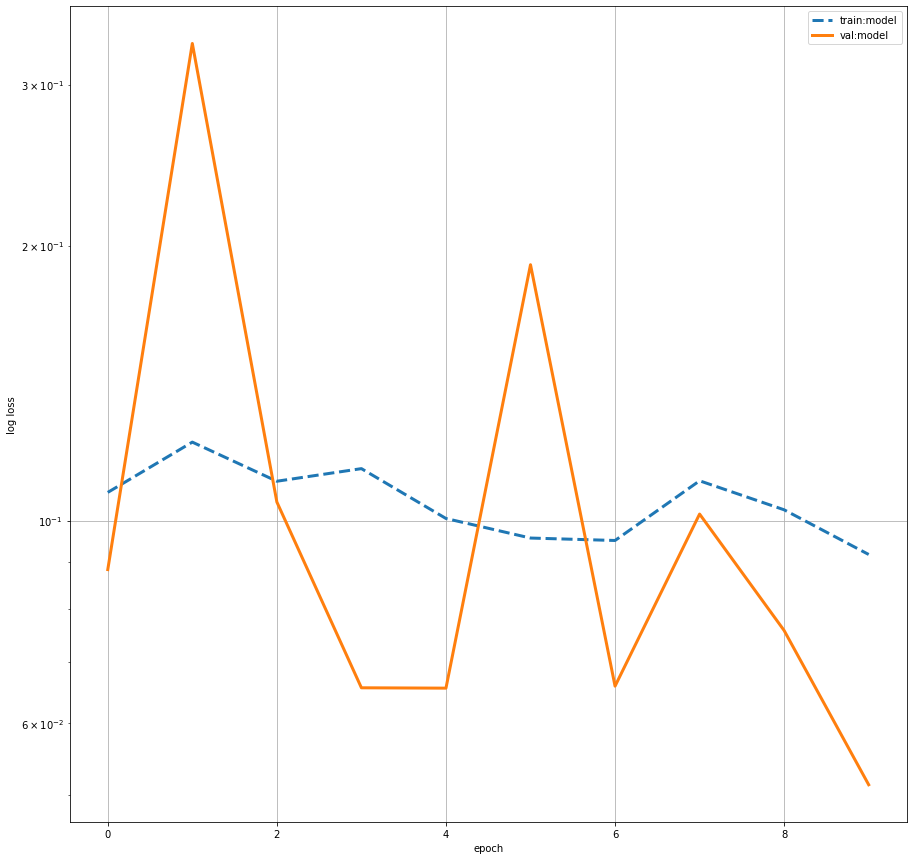

In [44]:
plt.figure(figsize=(15,15))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

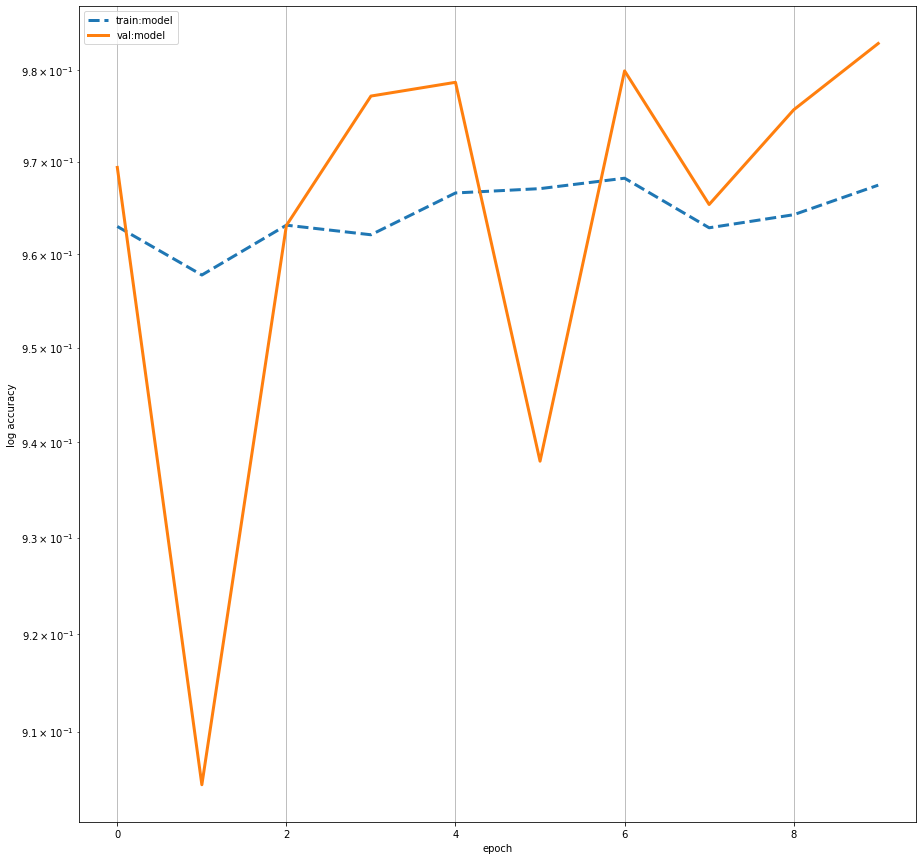

In [45]:
plt.figure(figsize=(15,15))
plot_accuracy(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

### Delete the existing model + Load the best one

In [46]:
# Delete the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")

<a id="confusion_matrix"></a>
## Look at confusion matrix

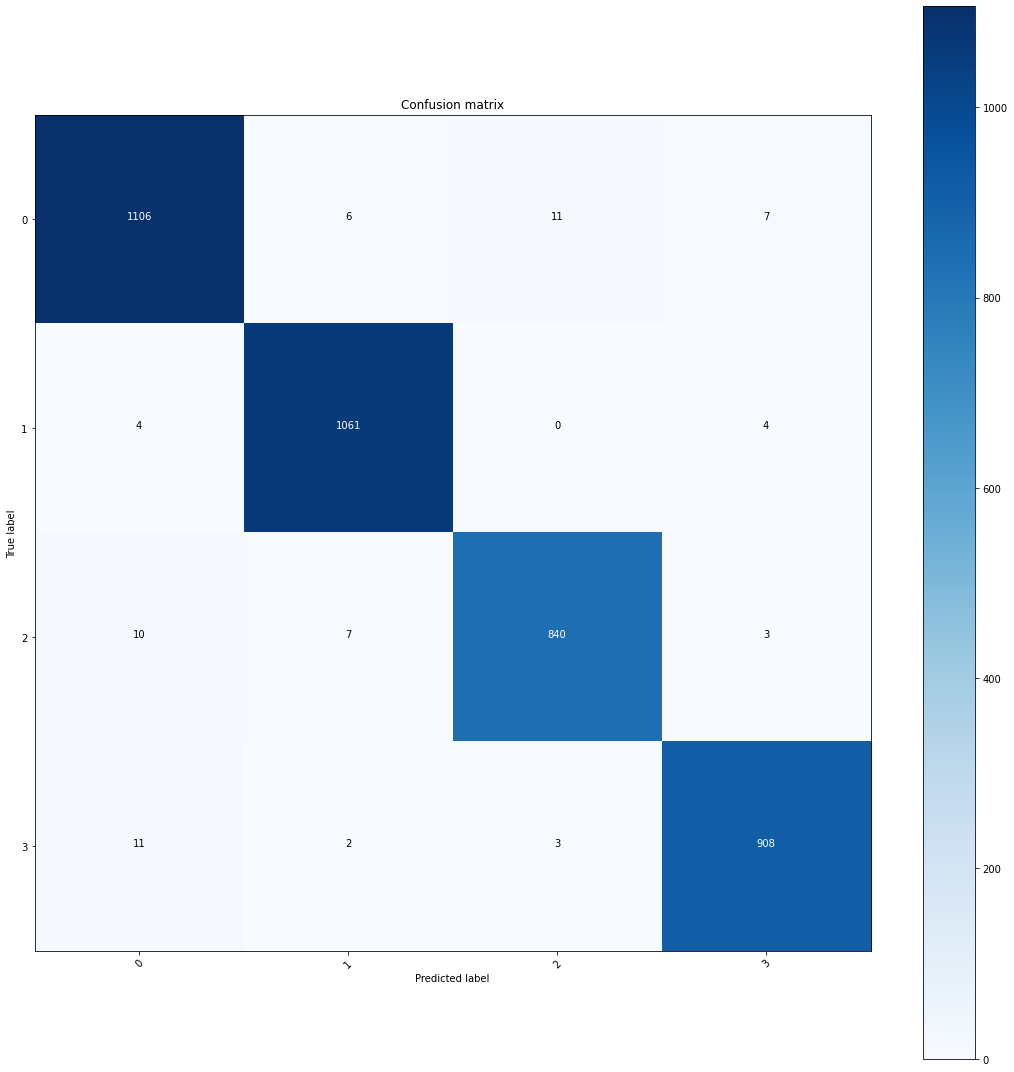

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

In [48]:
# Verify the shapes
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (3983, 4)
Y_pred_classes shape:  (3983,)
Y_true shape:  (3983,)
confusion_mtx shape:  (4, 4)


In [49]:
X_val.shape

(3983, 70, 70, 1)

<a id="analyze_errors"></a>
## Analyze the errors

In [50]:
# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [51]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 14))
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1.1)
    nb_pictures = len(errors_index)
    
    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//3 , 5, i+1, xticks=[], yticks=[]) 
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show() 

### Show the biggest errors

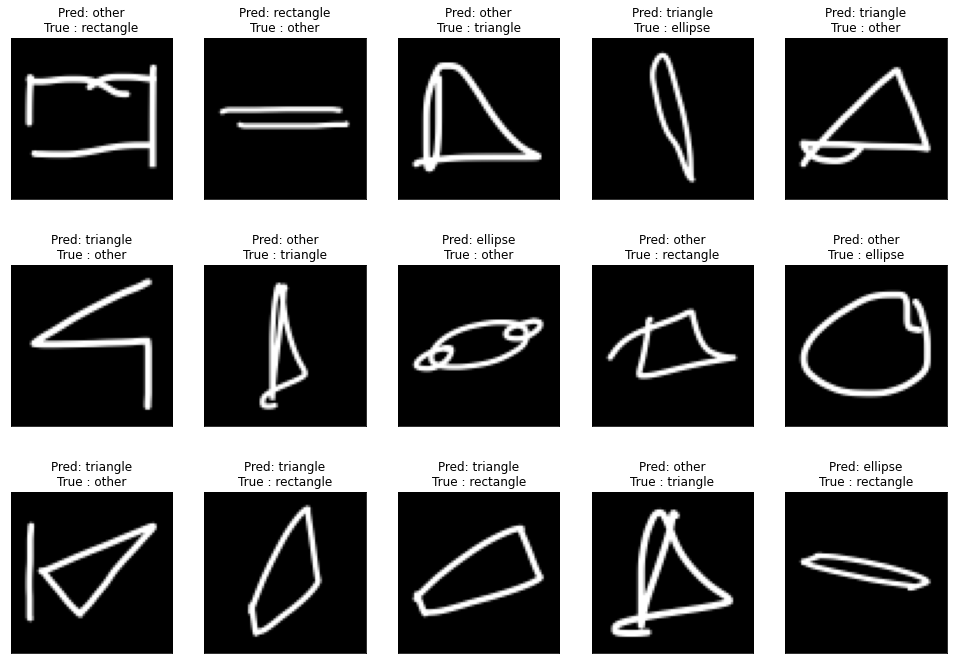

In [52]:
# Probabilities of the wrong predicted numbers. Prob for the bad choice
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set. Prob for the good choice
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top errors 
most_important_errors = sorted_delta_errors[-15:]

# Show the top errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [53]:
def saliency_map(input_image, model, label, image_size, num_classes):
    '''
    Generates the saliency map of a given gray scale image.

    Args:
        image -- picture that the model will classify
        model (Keras Model) -- classifier
        label (int) -- ground truth label of the image
        image_size (int)  -- Image size in pixels
        num_classes (int) -- number of classes for label
    '''

    input_image = input_image.reshape(image_size, image_size)
    
    # Add an additional dimension (for the batch)
    image = np.expand_dims(input_image, axis=0)

    # Define the expected output array by one-hot encoding the label
    # The length of the array is equal to the number of classes
    expected_output = tf.one_hot([label] * image.shape[0], num_classes)

    with tf.GradientTape() as tape:
        # cast image to float
        inputs = tf.cast(image, tf.float32)

        # watch the input pixels
        tape.watch(inputs)

        # generate the predictions
        predictions = model(inputs)

        # Calculate the loss
        loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

    # get the gradients of the loss with respect to the model's input image
    gradients = tape.gradient(loss, inputs)
    
    # generate the grayscale tensor
    grayscale_tensor = tf.abs(gradients[0])

    # The max value in the grayscale tensor will be pushed to 1.0
    # The min value will be pushed to 0.
    normalized_tensor = (grayscale_tensor - tf.reduce_min(grayscale_tensor)) / \
         (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor))
    
    # Mix the saliency map with the original image
    mixed_image = input_image * 0.5 + normalized_tensor * 0.5

    return mixed_image.numpy(), normalized_tensor.numpy()

In [54]:
def display_images_with_saliency_map(X, Y):
    """ This function shows Saliency maps for images with their real labels"""
    
    fig = plt.figure(figsize=(8, 29))
    fig.subplots_adjust(hspace=0.05, wspace=0.5, left=0, right=1, bottom=0, top=1.2)
    nb_pictures = 15
    m = 0
    
    for i in range(nb_pictures):
        image_with_saliency, normalized_tensor = saliency_map(X[i], model, Y[i], image_size, num_classes)
        
        if np.isnan(image_with_saliency[0,0]):
            # TODO Investigate when this condition occurs exactly
            continue

        ax = fig.add_subplot(nb_pictures, 3, (m*3)+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
        
        ax = fig.add_subplot(nb_pictures, 3, (m*3)+2, xticks=[], yticks=[]) 
        plot_sample(normalized_tensor.reshape((image_size, image_size)), ax)
        ax.set_title("Saliency")


        ax = fig.add_subplot(nb_pictures, 3, (m*3)+3, xticks=[], yticks=[]) 
        plot_sample(image_with_saliency.reshape((image_size, image_size)), ax)
        ax.set_title("Combined")
        
        m += 1

    plt.show()

### Do a visualization of which pixels the model is focusing on when making its predictions

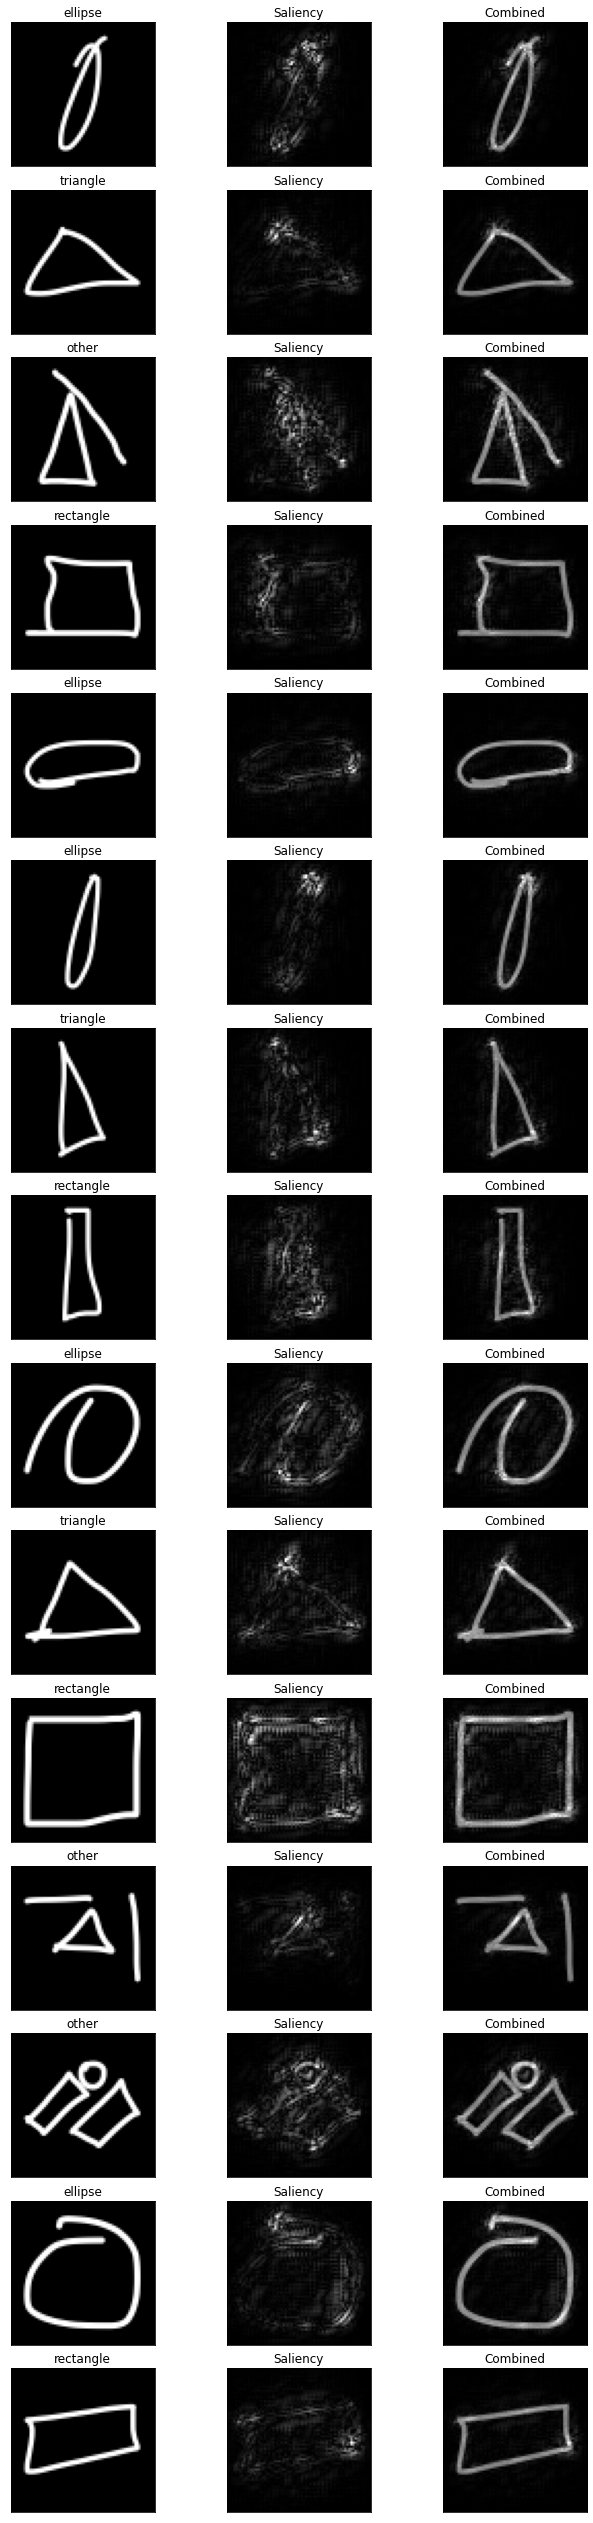

In [55]:
display_images_with_saliency_map(X_val[first_random_indexes_va], val_y[first_random_indexes_va])

In [56]:
## Prepare test set
test_X = test_data
test_y = test_labels
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test = test_X.reshape(-1, image_size, image_size, 1)
Y_test = to_categorical(test_y, num_classes=num_classes)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1923, 70, 70)
test_y shape:  (1923,)
X_test shape:  (1923, 70, 70, 1)
Y_test shape:  (1923, 4)


In [57]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("test_acc: ", test_acc)

61/61 [==============================] - 3s 40ms/step - loss: 0.0049 - accuracy: 0.9995
test_acc:  0.9994799494743347


In [58]:
# All done
datetime.datetime.now()

datetime.datetime(2024, 8, 11, 16, 14, 31, 975438)